<a href="https://colab.research.google.com/github/andreydesousa92-byte/ML_models/blob/main/Intermitent_Sales_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Describbing Business Case
Sales & order data for Northwind Traders, a fictitious gourmet food supplier, including information on customers, products, orders, shippers, and employees.


## Our Goal!

To predic at material level if next month there will be any sales or not

# Importing databases

In [1]:
import pandas as pd

In [2]:
# CATEGORIES
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/categories.csv"
df_categories = pd.read_csv(url)
df_categories.head()

,categoryID,categoryName,description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains & Cereals,"Breads, crackers, pasta, and cereal"


In [3]:
# CUSTOMERS
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/customers.csv"
df_customers = pd.read_csv(url, encoding='latin1')
df_customers.head()

,customerID,companyName,contactName,contactTitle,city,country
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Berlin,Germany
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Mexico City,Mexico
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mexico City,Mexico
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,London,UK
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Luleå,Sweden


In [4]:
# ORDERDETAILS
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/order_details.csv"
df_salesorders = pd.read_csv(url, encoding='latin1')
df_salesorders.head()

,orderID,productID,unitPrice,quantity,discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [5]:
# ORDERDETAILS
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/orders.csv"
df_orders = pd.read_csv(url)
df_orders.head()


,orderID,customerID,employeeID,orderDate,requiredDate,shippedDate,shipperID,freight
0,10248,VINET,5,2013-07-04,2013-08-01,2013-07-16,3,32.38
1,10249,TOMSP,6,2013-07-05,2013-08-16,2013-07-10,1,11.61
2,10250,HANAR,4,2013-07-08,2013-08-05,2013-07-12,2,65.83
3,10251,VICTE,3,2013-07-08,2013-08-05,2013-07-15,1,41.34
4,10252,SUPRD,4,2013-07-09,2013-08-06,2013-07-11,2,51.30


In [6]:
# Min and Max dates
min_date = df_orders['orderDate'].min()
max_date = df_orders['orderDate'].max()

print("Min order date:", min_date)
print("Max order date:", max_date)

Min order date: 2013-07-04
Max order date: 2015-05-06


In [7]:
# Create date range
calendar_df = pd.DataFrame({'Date': pd.date_range(start=min_date, end=max_date)})

# Extract year and month as separate columns
calendar_df['Year'] = calendar_df['Date'].dt.year
calendar_df['Month'] = calendar_df['Date'].dt.month
calendar_df['Day'] = calendar_df['Date'].dt.day

calendar_df.head(10)

,Date,Year,Month,Day
0,2013-07-04,2013,7,4
1,2013-07-05,2013,7,5
2,2013-07-06,2013,7,6
3,2013-07-07,2013,7,7
4,2013-07-08,2013,7,8
5,2013-07-09,2013,7,9
6,2013-07-10,2013,7,10
7,2013-07-11,2013,7,11
8,2013-07-12,2013,7,12
9,2013-07-13,2013,7,13


In [8]:
# ORDERDETAILS
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/products.csv"
df_products = pd.read_csv(url, encoding='latin1')
df_products.head()

,productID,productName,quantityPerUnit,unitPrice,discontinued,categoryID
0,1,Chai,10 boxes x 20 bags,18.00,0,1
1,2,Chang,24 - 12 oz bottles,19.00,0,1
2,3,Aniseed Syrup,12 - 550 ml bottles,10.00,0,2
3,4,Chef Anton's Cajun Seasoning,48 - 6 oz jars,22.00,0,2
4,5,Chef Anton's Gumbo Mix,36 boxes,21.35,1,2


# Transform
The first step is to connect the databases, using the sales orders database as the core source, and transform the data into features that will be useful for our model.
We are using sales orders instead of billed sales because orders better reflect the actual demand requested by customers.

In [9]:
!pip install duckdb
import duckdb

result_df  = duckdb.query("""
WITH
calendar AS(
    SELECT
        MIN(Date) AS Date,
        Year AS sales_year,
        Month AS sales_month
    FROM calendar_df
    group by
        Year,
        Month
),
parts_orgs AS (
    SELECT DISTINCT
        productID AS keyId
    FROM df_products
),
sales AS (
    SELECT
        YEAR(CAST(o.orderDate AS DATE)) AS sales_year,
        MONTH(CAST(o.orderDate AS DATE)) AS sales_month,
        so.productID AS keyId,
        SUM(so.quantity) AS Sales_EA,
        COUNT(*) AS Num_Sales_Orders,
        COUNT(DISTINCT o.customerID) AS Num_Of_Customers
    FROM df_orders o
    LEFT JOIN df_salesorders so
      ON o.OrderID = so.OrderID
    GROUP BY
        YEAR(CAST(o.orderDate AS DATE)) ,
        MONTH(CAST(o.orderDate AS DATE)),
        so.productID
    HAVING SUM(so.quantity) > 0
)
SELECT
    g.Date,
    g.sales_year,
    g.sales_month,
    g.keyId,
    COALESCE(s.Sales_EA, 0) AS Sales_EA,

    -- CAPTURES NEXT MONTH SALES
    LEAD(COALESCE(s.Sales_EA, 0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Next_Month_Sales_EA,

    -- BINARY TO INDICATE IF NEXT MONTH THERE WILL BE SALES OR NOT
    CASE
        WHEN
        LEAD(COALESCE(s.Sales_EA, 0)) OVER (
            PARTITION BY g.keyId
            ORDER BY g.sales_year, g.sales_month
        ) > 0
        THEN 1
        ELSE 0
    END AS Have_Sales_NMonth,

    -- SIN AND COS ARE RELEVANT FOR SEASONALITY
    SIN(2 * PI() * g.sales_month / 12) AS month_sin,
    COS(2 * PI() * g.sales_month / 12) AS month_cos,

    -- SALES LAGS
    LAG(COALESCE(s.Sales_EA, 0), 1) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Lag_1,
    LAG(COALESCE(s.Sales_EA, 0), 2) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Lag_2,
    LAG(COALESCE(s.Sales_EA, 0), 3) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Lag_3,

    -- ROLLING SUMS
    SUM(COALESCE(s.Sales_EA, 0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS Sum_Last_3_Months,

    -- MONTHS SINCE LAST SALES
    CASE
        WHEN MAX(CASE WHEN COALESCE(s.Sales_EA, 0) > 0 THEN (g.sales_year * 12 + g.sales_month) END)
             OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month
                   ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) IS NULL
        THEN 999
        ELSE (g.sales_year * 12 + g.sales_month) -
             MAX(CASE WHEN COALESCE(s.Sales_EA, 0) > 0 THEN (g.sales_year * 12 + g.sales_month) END)
                 OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month
                       ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
    END AS months_since_last_sale,

    -- L2M WITHOUT SALES RULE
    CASE
        WHEN
            LAG(COALESCE(s.Sales_EA, 0), 1) OVER (
                PARTITION BY g.keyId
                ORDER BY g.sales_year, g.sales_month
            ) = 0 AND
            LAG(COALESCE(s.Sales_EA, 0), 2) OVER (
                PARTITION BY g.keyId
                ORDER BY g.sales_year, g.sales_month
            ) =0
        THEN 1
        ELSE 0
    END AS no_sales_L2M,

    -- SALES TREND
    COALESCE(LAG(s.Sales_EA,1) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0) -
    COALESCE(LAG(s.Sales_EA,2) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0)
    AS Lag_Trend_1_2,

    COALESCE(LAG(s.Sales_EA,2) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0) -
    COALESCE(LAG(s.Sales_EA,3) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0)
    AS Lag_Trend_2_3,

    -- PERCENTAGE OF MONTHS WITH SALES
    SUM(
        CASE WHEN
            COALESCE(s.Sales_EA,0) > 0
        THEN 1 ELSE 0 END
    ) OVER (PARTITION BY g.keyId)
    /
    COUNT(*) OVER (PARTITION BY g.keyId)
    AS Product_Activity_Ratio,

    -- STANDARD DEVIATION OF LAST 6 MONTHS
    STDDEV(COALESCE(s.Sales_EA,0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) AS Sales_Std_6M,

    -- 6M ACITIVY RATE
    SUM(
        CASE WHEN COALESCE(s.Sales_EA,0) > 0 THEN 1 ELSE 0 END
    ) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) / 6.0 AS Activity_Rate_6M,

    -- 3M ACITIVY RATE
    SUM(
        CASE WHEN COALESCE(s.Sales_EA,0) > 0 THEN 1 ELSE 0 END
    ) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) / 3.0 AS Activity_Rate_3M,

    -- RECENCY INTERACTION
    Product_Activity_Ratio * months_since_last_sale AS Activity_Recency_Interaction,

    -- SEASONALITY INTERACTION
    month_sin * Product_Activity_Ratio AS Season_Activity_Interaction,

    -- NUMBER OF CUSTOMERS ON LAST 6M
    SUM(COALESCE(s.Num_Of_Customers,0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) AS Num_Customers_L6M,

    -- NUMBER OF SALES ORDERS
    SUM(COALESCE(s.Num_Sales_Orders,0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) AS Num_SalesOrders_L6M

FROM (
    SELECT
        c.Date,
        c.sales_year,
        c.sales_month,
        p.keyId
    FROM calendar c
    CROSS JOIN parts_orgs p
) g
LEFT JOIN sales s
    ON g.sales_year = s.sales_year
   AND g.sales_month = s.sales_month
   AND g.keyId = s.keyId
ORDER BY
    g.keyId,
    g.sales_year,
    g.sales_month;
""").to_df()

In [10]:
result_df.head()

,Date,sales_year,sales_month,keyId,Sales_EA,Next_Month_Sales_EA,Have_Sales_NMonth,month_sin,month_cos,Sales_Lag_1,...,Lag_Trend_1_2,Lag_Trend_2_3,Product_Activity_Ratio,Sales_Std_6M,Activity_Rate_6M,Activity_Rate_3M,Activity_Recency_Interaction,Season_Activity_Interaction,Num_Customers_L6M,Num_SalesOrders_L6M
0,2013-07-04,2013,7,1,0.0,63.0,1,-0.500000,-8.660254e-01,NaN,...,0.0,0.0,0.782609,NaN,0.000000,0.000000,781.826087,-0.391304,0.0,0.0
1,2013-08-01,2013,8,1,63.0,20.0,1,-0.866025,-5.000000e-01,0.0,...,0.0,0.0,0.782609,44.547727,0.166667,0.333333,0.000000,-0.677759,2.0,2.0
2,2013-09-01,2013,9,1,20.0,0.0,0,-1.000000,-1.836970e-16,63.0,...,63.0,0.0,0.782609,32.192132,0.333333,0.666667,0.000000,-0.782609,3.0,3.0
3,2013-10-01,2013,10,1,0.0,27.0,1,-0.866025,5.000000e-01,20.0,...,-43.0,63.0,0.782609,29.702693,0.333333,0.666667,0.782609,-0.677759,3.0,3.0
4,2013-11-01,2013,11,1,27.0,15.0,1,-0.500000,8.660254e-01,0.0,...,-20.0,-43.0,0.782609,25.874698,0.500000,0.666667,0.000000,-0.391304,5.0,5.0


# Nominating Features

In [11]:
feature_cols = [
    # "month_sin",
    "month_cos",
    # "Sales_Lag_1",
    # "Sales_Lag_2",
    # "Sales_Lag_3",
    "Sum_Last_3_Months",
    "months_since_last_sale",
    "no_sales_L2M",
    "Sales_Std_6M",
    "Product_Activity_Ratio",
    "Lag_Trend_1_2",
    "Lag_Trend_2_3",
    "Activity_Rate_6M",
    "Activity_Rate_3M",
    "Activity_Recency_Interaction",
    "Season_Activity_Interaction",
    "Num_Customers_L6M",
    "Num_SalesOrders_L6M"
]

In [12]:
label_col = ["Have_Sales_NMonth"]

# Analytics

We'll check percentage of cases where sales are intermitent, which means the material doesn't sell on the month after

In [13]:
num_ones = (result_df['Have_Sales_NMonth'] == 1).sum()
total_rows = len(result_df)
percentage = (num_ones / total_rows) * 100

print(f"Percentage of rows with Have_Sales_NMonth = 1: {percentage:.2f}%")

Percentage of rows with Have_Sales_NMonth = 1: 63.35%


An Histogram will help us to identify the distribution of ratio.

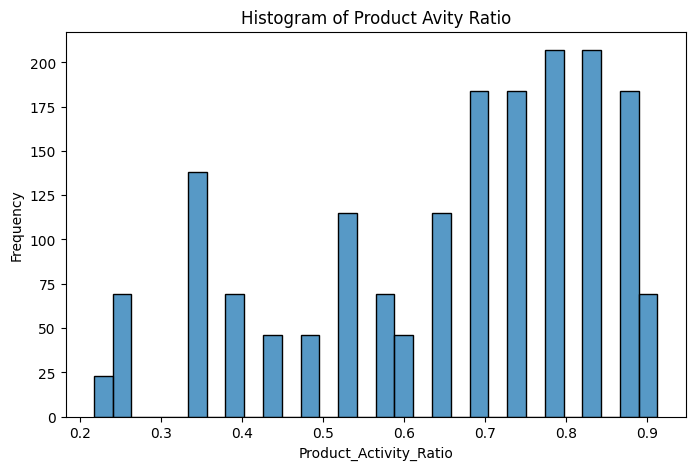

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(result_df["Product_Activity_Ratio"], bins=30)

plt.title("Histogram of Product Avity Ratio")
plt.xlabel("Product_Activity_Ratio")
plt.ylabel("Frequency")
plt.show()

Group those cases will help to better indentify the chellange

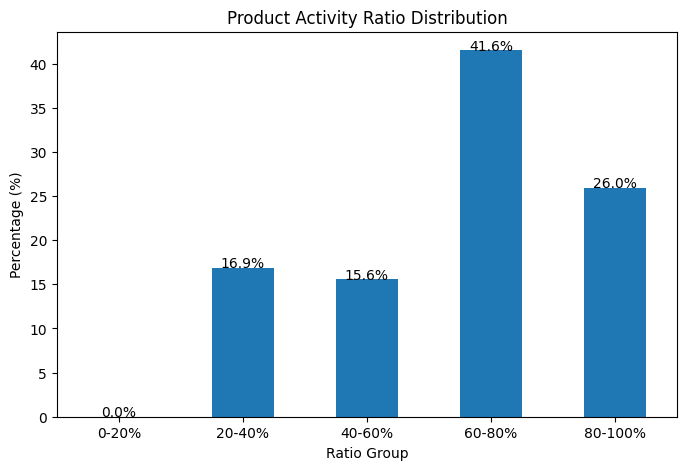

In [15]:
# If ratio is between 0 and 1, keep bins like this:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"]

# Create grouped variable
result_df["Product_Activity_Group"] = pd.cut(
    result_df["Product_Activity_Ratio"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Calculate percentage distribution
group_percent = (
    result_df["Product_Activity_Group"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

# Plot
plt.figure(figsize=(8,5))
ax = group_percent.plot(kind="bar")

# Add percentage labels on bars
for i, v in enumerate(group_percent):
    ax.text(i, v, f"{v:.1f}%", ha="center")

plt.title("Product Activity Ratio Distribution")
plt.xlabel("Ratio Group")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)

plt.show()

## Correlation Matrix
The Correlation Matrix is an important step to identify how features influence one another

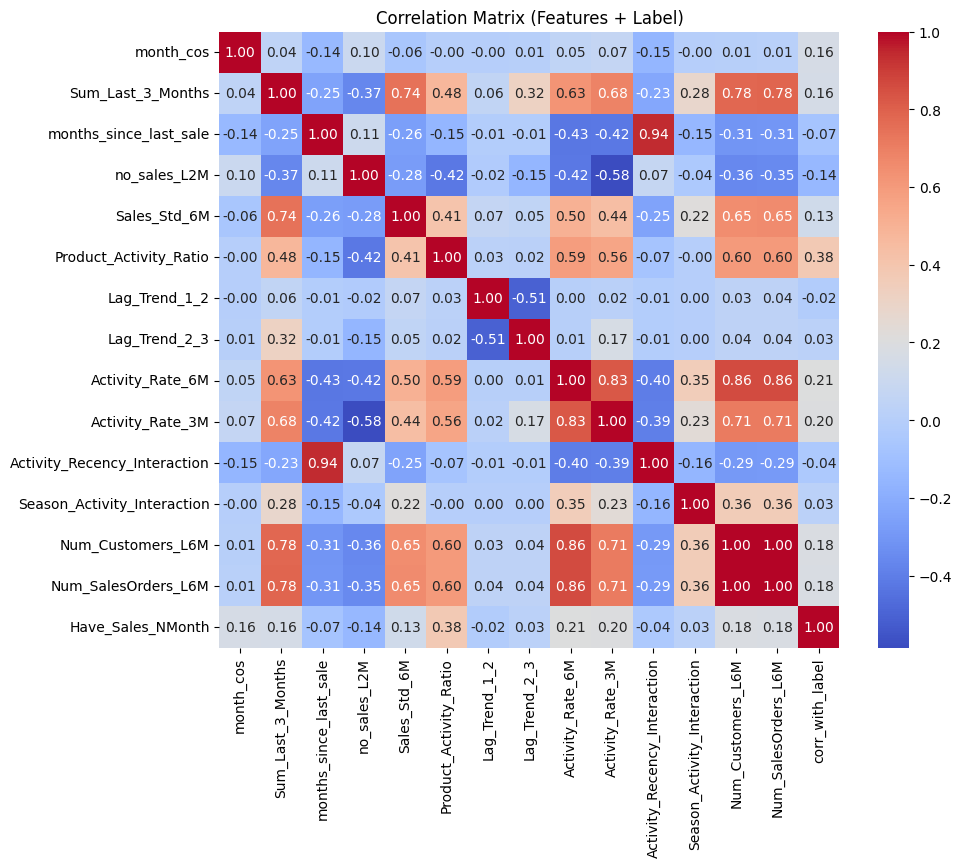

In [16]:
# Feature-feature correlations
cor_matrix = result_df[feature_cols].corr(method='pearson')

# Correlation with label
label_name = label_col[0]  # e.g., "Have_Sales_NMonth"
label_corrs = result_df[feature_cols].apply(lambda x: x.corr(result_df[label_name]))

# Add as a column
cor_matrix["corr_with_label"] = label_corrs

# Add label row
label_row = label_corrs.tolist() + [1.0]  # label correlation with itself
cor_matrix.loc[label_name] = label_row

plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (Features + Label)")
plt.show()

# Splitting Training and Validation & Scaling features

In [17]:
# Split train and val
split_date = pd.to_datetime('2015-01-01')
train_df = result_df[result_df['Date'] < split_date]
val_df = result_df[result_df['Date'] >= split_date]

In [18]:
from sklearn.preprocessing import StandardScaler

# Select features + label (Pandas)
train_pd = train_df[feature_cols + label_col].copy()
val_pd = val_df[feature_cols + label_col].copy()

# drop NA's
train_pd = train_pd.dropna()
val_pd = val_pd.dropna()

# Separate X and y
X_train = train_pd[feature_cols].values
Y_train = train_pd[label_col[0]].values

X_val = val_pd[feature_cols].values
Y_val = val_pd[label_col[0]].values

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [19]:
import numpy as np
print("Shape X:", X_train.shape)
print("Shape y:", Y_train.shape)

print("NaNs X:", np.isnan(X_train).sum())
print("NaNs y:", np.isnan(Y_train).sum())

print("Unique y:", np.unique(Y_train))
print("Positive rate:", np.mean(Y_train))

print("Max X:", np.max(X_train))
print("Min X:", np.min(X_train))

Shape X: (1309, 14)
Shape y: (1309,)
NaNs X: 0
NaNs y: 0
Unique y: [0 1]
Positive rate: 0.6478227654698243
Max X: 8.31005636371969
Min X: -4.242475042645174


# Naive Baselines

## Always predict 1 (will be a sale)

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

y_pred_all1 = np.ones(len(Y_val))

acc_all1 = accuracy_score(Y_val, y_pred_all1)
print("Accuracy - Always 1:", acc_all1)

auc_all1 = roc_auc_score(Y_val, y_pred_all1)
print("AUC - Always 1:", auc_all1)

Accuracy - Always 1: 0.5974025974025974
AUC - Always 1: 0.5


## Rule: months_since_last_sale > 3 → predict 0

In [21]:
y_pred_rule_3 = (val_pd["months_since_last_sale"] <= 3).astype(int)

acc_rule_3 = accuracy_score(Y_val, y_pred_rule_3)
print("Accuracy - Rule >3:", acc_rule_3)

auc_rule_3 = roc_auc_score(Y_val, y_pred_rule_3)
print("AUC - Rule <=3:", auc_rule_3)

Accuracy - Rule >3: 0.6077922077922078
AUC - Rule <=3: 0.5160589060308556


## Rule: months_since_last_sale > 2 → predict 0

In [22]:
y_pred_rule_2 = (val_pd["months_since_last_sale"] <= 2).astype(int)

acc_rule_2 = accuracy_score(Y_val, y_pred_rule_2)
print("Accuracy - Rule >2:", acc_rule_2)

auc_rule_2 = roc_auc_score(Y_val, y_pred_rule_2)
print("AUC - Rule <=2:", auc_rule_2)

Accuracy - Rule >2: 0.6181818181818182
AUC - Rule <=2: 0.5300140252454417


# Deep Learning

In [23]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

model = Sequential([
    Dense(16, activation="relu", input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.2),
    Dense(5, activation="relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
from tensorflow.keras.optimizers import Adam
# optimizer = Adam(learning_rate=0.0005)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["AUC", "accuracy"]
)

In [25]:
early_stop = EarlyStopping(monitor='val_AUC',mode='max', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - AUC: 0.4620 - accuracy: 0.6589 - loss: 0.7041 - val_AUC: 0.4765 - val_accuracy: 0.5974 - val_loss: 0.6854
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.5285 - accuracy: 0.6639 - loss: 0.6655 - val_AUC: 0.5807 - val_accuracy: 0.5974 - val_loss: 0.6739
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.5965 - accuracy: 0.6407 - loss: 0.6460 - val_AUC: 0.6083 - val_accuracy: 0.5974 - val_loss: 0.6839
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.6235 - accuracy: 0.6638 - loss: 0.6232 - val_AUC: 0.6215 - val_accuracy: 0.5974 - val_loss: 0.6883
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6679 - accuracy: 0.6506 - loss: 0.6164 - val_AUC: 0.6271 - val_accuracy: 0.5974 - val_loss: 0.6949
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6619 - accuracy: 0.6406 - loss: 0.6181 - val_AUC: 0.6331 - val_accuracy: 0.5974 - val_loss: 0.6835
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/s

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 995 (3.89 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 664 (2.60 KB)

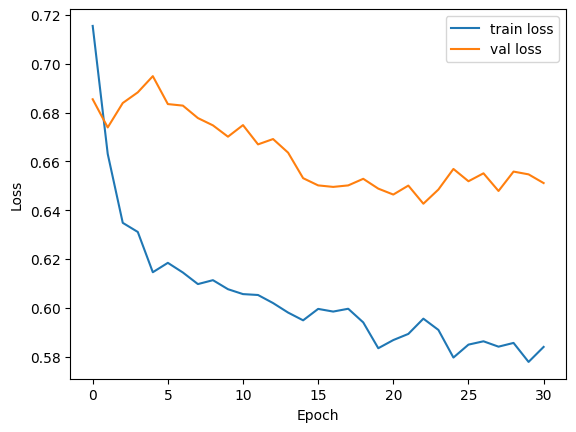

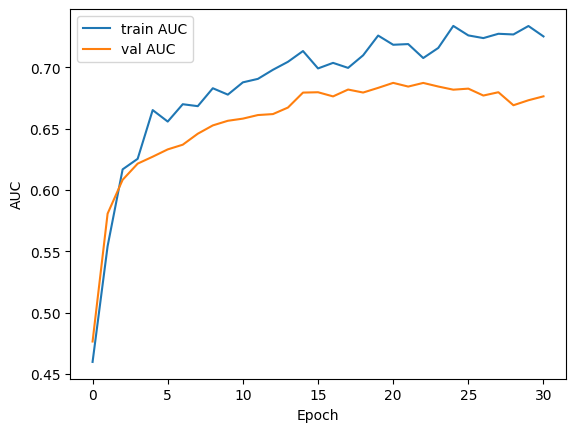

In [27]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['AUC'], label='train AUC')
plt.plot(history.history['val_AUC'], label='val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [28]:
loss, auc, acc = model.evaluate(X_val, Y_val)
lossT, aucT, accT = model.evaluate(X_train, Y_train)

print("Train Loss: ", lossT)
print("Train Auc: ", aucT)
print("Train Accuracy: ", accT)

print("Validation Loss: ", loss)
print("Validation Auc: ", auc)
print("Validation ACcuracy: ", acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7098 - accuracy: 0.6747 - loss: 0.6191 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7393 - accuracy: 0.6834 - loss: 0.5961
Train Loss:  0.5733880400657654
Train Auc:  0.7471989393234253
Train Accuracy:  0.7097020745277405
Validation Loss:  0.646430253982544
Validation Auc:  0.6873071789741516
Validation ACcuracy:  0.6415584683418274


In [29]:
from sklearn.metrics import accuracy_score

# Get probabilities from your model
y_pred_prob = model.predict(X_val).ravel()

# Try multiple thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)
    acc = accuracy_score(Y_val, y_pred)
    print(f"Threshold {t:.2f} → Accuracy {acc:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Threshold 0.10 → Accuracy 0.597
Threshold 0.15 → Accuracy 0.597
Threshold 0.20 → Accuracy 0.597
Threshold 0.25 → Accuracy 0.597
Threshold 0.30 → Accuracy 0.597
Threshold 0.35 → Accuracy 0.597
Threshold 0.40 → Accuracy 0.597
Threshold 0.45 → Accuracy 0.597
Threshold 0.50 → Accuracy 0.642
Threshold 0.55 → Accuracy 0.668
Threshold 0.60 → Accuracy 0.681
Threshold 0.65 → Accuracy 0.655
Threshold 0.70 → Accuracy 0.634
Threshold 0.75 → Accuracy 0.613
Threshold 0.80 → Accuracy 0.548
Threshold 0.85 → Accuracy 0.468


# Logistic Regression Method

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

# Initialize model
log_model = LogisticRegression(max_iter=1000)

# Train
log_model.fit(X_train, Y_train)

# Get predicted probabilities
y_prob = log_model.predict_proba(X_val)[:, 1]

# Compute AUC
log_auc = roc_auc_score(Y_val, y_prob)
log_accuracy = accuracy_score(Y_val, y_pred)
logm_loss = log_loss(Y_val, y_prob)


print("Logistic Regression Validation AUC:", log_auc)
print("Log Loss:", logm_loss)
print("Accuracy:", log_accuracy)

Logistic Regression Validation AUC: 0.6818232819074334
Log Loss: 0.6367291455945036
Accuracy: 0.4675324675324675


In [31]:
# Extract coefficients
coefs = log_model.coef_[0]

# Create a DataFrame for easy viewing
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefs,
    'Abs_Coefficient': abs(coefs)
})

# Sort by absolute value to see most influential features
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

feature_importance

,Feature,Coefficient,Abs_Coefficient
5,Product_Activity_Ratio,0.998383,0.998383
12,Num_Customers_L6M,0.764592,0.764592
13,Num_SalesOrders_L6M,-0.681788,0.681788
9,Activity_Rate_3M,-0.240997,0.240997
10,Activity_Recency_Interaction,-0.188609,0.188609
0,month_cos,0.153093,0.153093
2,months_since_last_sale,0.138521,0.138521
1,Sum_Last_3_Months,-0.137971,0.137971
4,Sales_Std_6M,0.136599,0.136599
7,Lag_Trend_2_3,0.130846,0.130846


## Random Forest Model

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train, Y_train)

# Predict probabilities
rf_val_probs = rf_model.predict_proba(X_val)[:, 1]

# Class predictions (threshold 0.5)
rf_val_preds = (rf_val_probs >= 0.5).astype(int)

rf_auc = roc_auc_score(Y_val, rf_val_probs)
rf_acc = accuracy_score(Y_val, rf_val_preds)
rf_loss = log_loss(Y_val, rf_val_probs)

print("Random Forest Results")
print("AUC:", rf_auc)
print("Accuracy:", rf_acc)
print("Log Loss:", rf_loss)

Random Forest Results
AUC: 0.6838148667601682
Accuracy: 0.6779220779220779
Log Loss: 0.6313810764929761


## XBoost Model

In [33]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

xgb_model.fit(
    X_train,
    Y_train,
    eval_set=[(X_val, Y_val)],
    verbose=False
)

# Predict probabilities
xgb_val_probs = xgb_model.predict_proba(X_val)[:, 1]

# Class predictions (threshold 0.5)
xgb_val_preds = (xgb_val_probs >= 0.5).astype(int)

xgb_auc = roc_auc_score(Y_val, xgb_val_probs)
xgb_acc = accuracy_score(Y_val, xgb_val_preds)
xgb_loss = log_loss(Y_val, xgb_val_probs)

print("XGBoost Results")
print("AUC:", xgb_auc)
print("Accuracy:", xgb_acc)
print("Log Loss:", xgb_loss)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:32:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results
AUC: 0.6582047685834502
Accuracy: 0.6545454545454545
Log Loss: 0.7702016368590964


# Comparing All Models

In [34]:
results = pd.DataFrame({
    "Model": [
        "XGBoost",
        "Random Forest",
        "Logistic Regression",
        "Deep Learning"
    ],
    "AUC": [
        xgb_auc,
        rf_auc,
        log_auc,
        auc
    ],
    "Accuracy": [
        xgb_acc,
        rf_acc,
        log_accuracy,
        acc
    ],
    "Log Loss": [
        xgb_loss,
        rf_loss,
        logm_loss,
        loss
    ]
})

results.sort_values(by="AUC", ascending=False)

,Model,AUC,Accuracy,Log Loss
3,Deep Learning,0.687307,0.467532,0.646430
1,Random Forest,0.683815,0.677922,0.631381
2,Logistic Regression,0.681823,0.467532,0.636729
0,XGBoost,0.658205,0.654545,0.770202
